

```
# This is formatted as code
```

Empezamos nuestro obligatorio, con el objetivo de limpiar y estandarizar los datos de prueba para tener mejor resultado en un futuro.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [31]:
class TransformtionItem:
    def __init__(self, transform_fn, untransform_fn, columns=None):
        self.transform_fn = transform_fn
        self.untransform_fn = untransform_fn
        self.columns = columns

    def transform(self, data):
        if isinstance(data, pd.DataFrame):
            data = data.copy()
            cols_to_transform = self.columns if self.columns is not None else data.select_dtypes(include=np.number).columns
            for col in cols_to_transform:
                if col in data.columns: # Check if column exists in the DataFrame
                    data[col] = self.transform_fn(data[col].to_numpy())
            return data

        elif isinstance(data, (np.ndarray, pd.Series, list)):
            arr = np.asarray(data)
            return self.transform_fn(arr)

        else:
            raise TypeError(f"Unsupported data type for transform: {type(data)}")

    def untransform(self, data):
        if isinstance(data, pd.DataFrame):
            data = data.copy()
            cols_to_untransform = self.columns if self.columns is not None else data.select_dtypes(include=np.number).columns
            for col in cols_to_untransform:
                 if col in data.columns: # Check if column exists in the DataFrame
                    data[col] = self.untransform_fn(data[col].to_numpy())
            return data

        elif isinstance(data, (np.ndarray, pd.Series, list)):
            arr = np.asarray(data)
            return self.untransform_fn(arr)

        else:
            raise TypeError(f"Unsupported data type for untransform: {type(data)}")

class TransformationArray:
    def __init__(self, items):
        # Expect a list of TransformableItem objects
        self.items = items

    def transform(self, df):
        for item in self.items:
            df = item.transform(df)
        return df

    def untransform(self, df):
        for item in reversed(self.items):
            df = item.untransform(df)
        return df

In [32]:
columns_to_transform = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'last_review', 'days_since_last_review', 'weekss_since_last_review', 'months_since_last_review', 'quarters_since_last_review', 'years_since_last_review']
transform = TransformationArray([
    TransformtionItem(
        lambda df: np.log1p(df),
        lambda df: np.expm1(df),
        columns=columns_to_transform
    )
]);

In [33]:
outliersAfter = 0
outliersBefore = 0
outliersLower = 0.25
outliersUpper = 0.75
columnaDistanciaCentro = 1
lastReviewDate = 1
daysSinceLastReview = 1
weeksSinceLastReview = 1
monthsSinceLastReview = 1
quartersSinceLastReview = 1
yearSinceLastReview = 1
categoryMinimimNight = 1
hostMultipleListing = 1
reviewRatio = 1
BBAACenter = [-34.59977951146896, -58.38320368379193] # [Latitud, Longitud]

In [34]:
df = pd.read_csv('../sample_data/train.csv')
dfTest = pd.read_csv('../sample_data/test.csv')

if columnaDistanciaCentro != 0:
    df['distance_to_center'] = np.sqrt((df['latitude'] - BBAACenter[0])**2 + (df['longitude'] - BBAACenter[1])**2)
    dfTest['distance_to_center'] = np.sqrt((dfTest['latitude'] - BBAACenter[0])**2 + (dfTest['longitude'] - BBAACenter[1])**2)

# Calculate timedelta in days first, as 'M' and 'Y' are not supported units for np.timedelta64
time_diff_df = pd.to_datetime('today') - pd.to_datetime(df['last_review'].fillna('01-01-1970'), dayfirst=True)
time_diff_dfTest = pd.to_datetime('today') - pd.to_datetime(dfTest['last_review'].fillna('01-01-1970'), dayfirst=True)

if daysSinceLastReview != 0:
    df['days_since_last_review'] = time_diff_df / np.timedelta64(1, 'D')
    dfTest['days_since_last_review'] = time_diff_dfTest / np.timedelta64(1, 'D')

if weeksSinceLastReview != 0:
    df['weeks_since_last_review'] = time_diff_df / np.timedelta64(1, 'W')
    dfTest['weeks_since_last_review'] = time_diff_dfTest / np.timedelta64(1, 'W')

if monthsSinceLastReview != 0:
    # Approximate months by dividing days by average days in a month (365.25 days/year / 12 months/year)
    df['months_since_last_review'] = (time_diff_df / np.timedelta64(1, 'D')) / 30.4375
    dfTest['months_since_last_review'] = (time_diff_dfTest / np.timedelta64(1, 'D')) / 30.4375

if quartersSinceLastReview != 0:
    # Approximate quarters by dividing days by average days in a quarter (365.25 days/year / 4 quarters/year)
    df['quarters_since_last_review'] = (time_diff_df / np.timedelta64(1, 'D')) / 91.3125
    dfTest['quarters_since_last_review'] = (time_diff_dfTest / np.timedelta64(1, 'D')) / 91.3125

if yearSinceLastReview != 0:
    # Approximate years by dividing days by average days in a year
    df['years_since_last_review'] = (time_diff_df / np.timedelta64(1, 'D')) / 365.25
    dfTest['years_since_last_review'] = (time_diff_dfTest / np.timedelta64(1, 'D')) / 365.25

if lastReviewDate != 0:
    df['last_review'] = pd.to_datetime(df['last_review'].fillna('01-01-1970'), dayfirst=True).astype('int64')
    dfTest['last_review'] = pd.to_datetime(dfTest['last_review'].fillna('01-01-1970'), dayfirst=True).astype('int64')
else:
    df = df.drop(['last_review'], axis=1)
    dfTest = dfTest.drop(['last_review'], axis=1)

if categoryMinimimNight != 0:
    df['minimum_nights_category'] = pd.cut(df['minimum_nights'], bins=[0,7,30,180,365,10000],
                                       labels=['short','week','month','semi_year','long'])
    dfTest['minimum_nights_category'] = pd.cut(dfTest['minimum_nights'], bins=[0,7,30,180,365,10000],
                                           labels=['short','week','month','semi_year','long'])

if hostMultipleListing != 0:
    df['host_has_multiple_listings'] = df['calculated_host_listings_count'] > 1
    dfTest['host_has_multiple_listings'] = dfTest['calculated_host_listings_count'] > 1

if reviewRatio != 0:
    df['reviews_ratio'] = df['number_of_reviews'] / (df['days_since_last_review'] + 1)
    dfTest['reviews_ratio'] = dfTest['number_of_reviews'] / (dfTest['days_since_last_review'] + 1)

mean = np.mean(df['price'])
median = np.median(df['price'])

print("Mean: ", mean)
print("Median: ", median)
print("Original shape:", df.shape)
print(df.info())

df = df.drop(['name', 'id', 'host_id', 'host_name', 'availability_365'], axis=1)
dfTest = dfTest.drop(['name', 'id', 'host_id', 'host_name', 'availability_365'], axis=1)

Mean:  3286.0970461500033
Median:  2033.0
Original shape: (16013, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16013 entries, 0 to 16012
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              16013 non-null  int64   
 1   name                            16005 non-null  object  
 2   host_id                         16013 non-null  int64   
 3   host_name                       16000 non-null  object  
 4   neighbourhood                   16013 non-null  object  
 5   latitude                        16013 non-null  float64 
 6   longitude                       16013 non-null  float64 
 7   room_type                       16013 non-null  object  
 8   price                           16013 non-null  int64   
 9   minimum_nights                  16013 non-null  int64   
 10  number_of_reviews               16013 non-null  int64   
 11  last_revie

# New Section

In [35]:
categorical_cols = ['room_type', 'neighbourhood'] #, 'minimum_nights_category']
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric features: {numeric_cols}")
print(f"Categorical features: {categorical_cols}")


Numeric features: ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'distance_to_center', 'days_since_last_review', 'weeks_since_last_review', 'months_since_last_review', 'quarters_since_last_review', 'years_since_last_review', 'reviews_ratio']
Categorical features: ['room_type', 'neighbourhood']


In [36]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
dfTest['reviews_per_month'] = dfTest['reviews_per_month'].fillna(0)

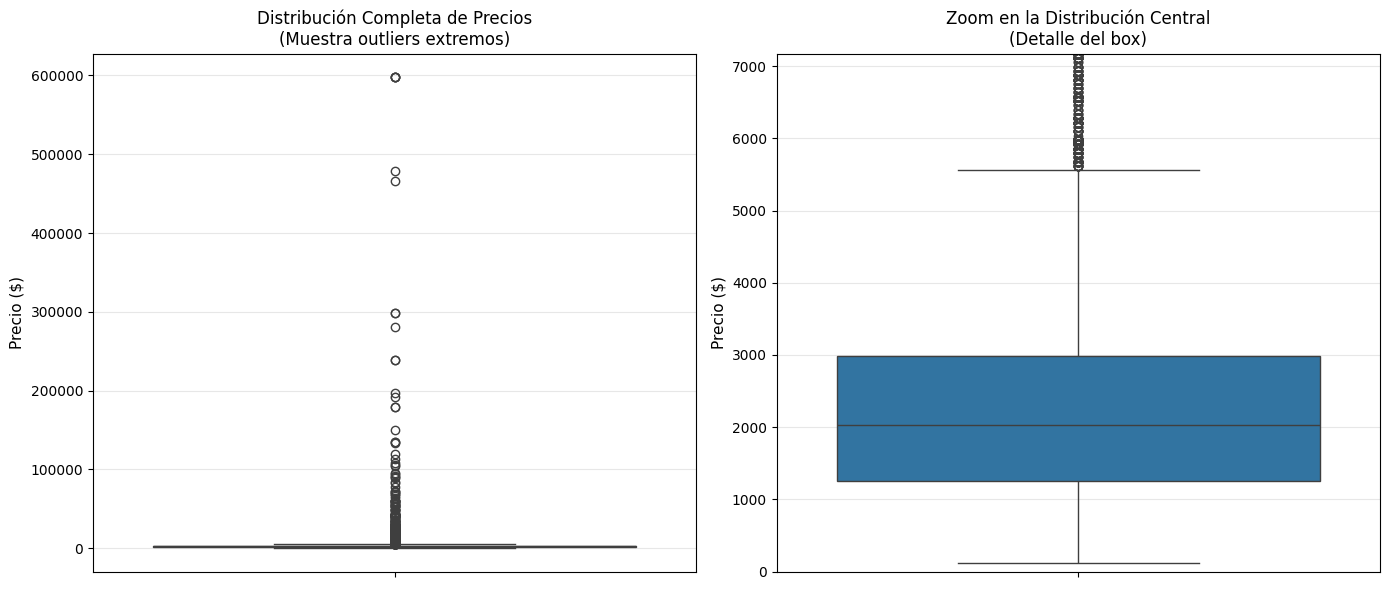


ANÁLISIS DE OUTLIERS EN PRICE
Q1 (25%):              $1,256.00
Mediana (50%):         $2,033.00
Q3 (75%):              $2,990.00
IQR:                   $1,734.00

Límite inferior:       $-1,345.00
Límite superior:       $5,591.00

Mínimo:                $120.00
Máximo:                $597,865.00

Outliers inferiores:   0 (normal que sea 0)
Outliers superiores:   1397 (8.72%)


In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Escala completa (muestra todos los outliers superiores)
sns.boxplot(y=df['price'], ax=axes[0])
axes[0].set_title('Distribución Completa de Precios\n(Muestra outliers extremos)', fontsize=12)
axes[0].set_ylabel('Precio ($)', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Zoom en la caja (para ver mejor el IQR)
sns.boxplot(y=df['price'], ax=axes[1])
axes[1].set_title('Zoom en la Distribución Central\n(Detalle del box)', fontsize=12)
axes[1].set_ylabel('Precio ($)', fontsize=11)
axes[1].set_ylim(0, df['price'].quantile(0.95))  # Muestra hasta el percentil 95
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
limite_sup = Q3 + 1.5 * IQR
limite_inf = Q1 - 1.5 * IQR
outliers_sup = df[df['price'] > limite_sup]
outliers_inf = df[df['price'] < limite_inf]

print(f"\n{'='*50}")
print("ANÁLISIS DE OUTLIERS EN PRICE")
print(f"{'='*50}")
print(f"Q1 (25%):              ${Q1:,.2f}")
print(f"Mediana (50%):         ${df['price'].median():,.2f}")
print(f"Q3 (75%):              ${Q3:,.2f}")
print(f"IQR:                   ${IQR:,.2f}")
print(f"\nLímite inferior:       ${limite_inf:,.2f}")
print(f"Límite superior:       ${limite_sup:,.2f}")
print(f"\nMínimo:                ${df['price'].min():,.2f}")
print(f"Máximo:                ${df['price'].max():,.2f}")
print(f"\nOutliers inferiores:   {len(outliers_inf)} (normal que sea 0)")
print(f"Outliers superiores:   {len(outliers_sup)} ({len(outliers_sup)/len(df)*100:.2f}%)")

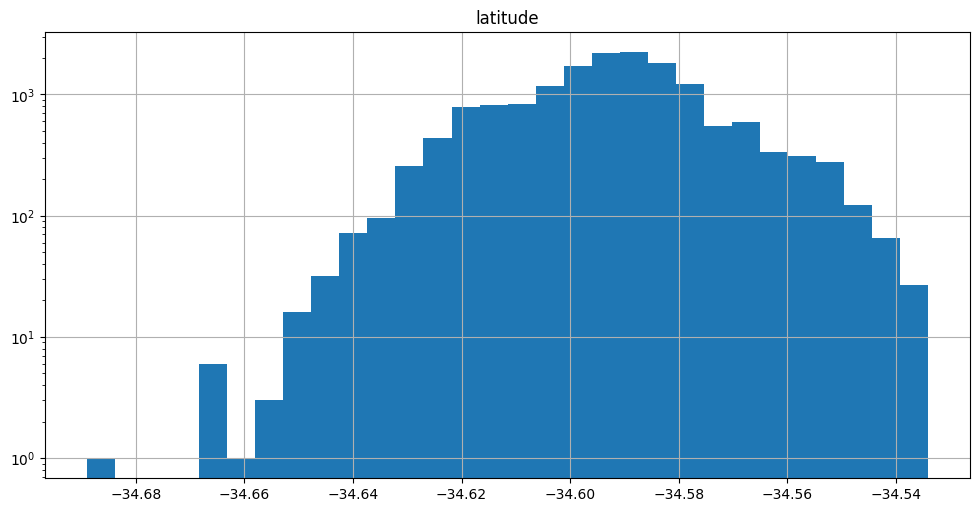

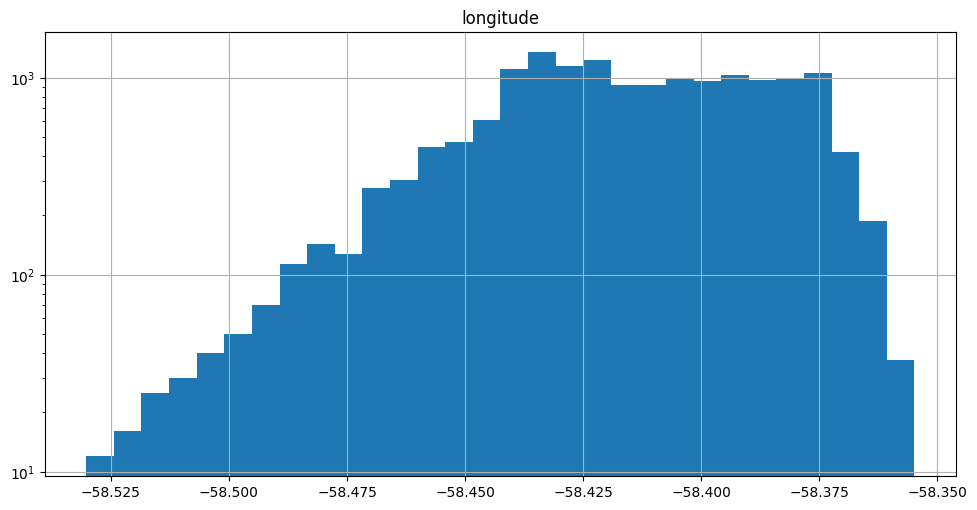

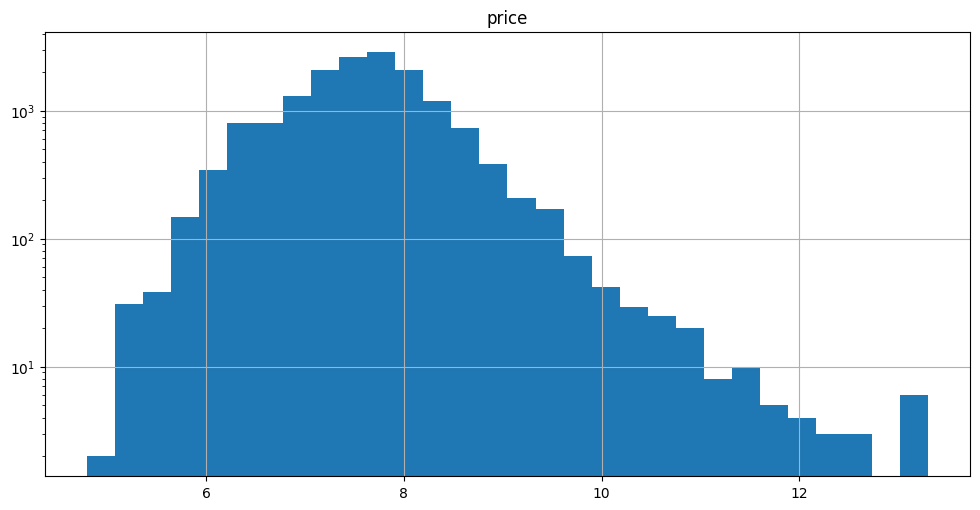

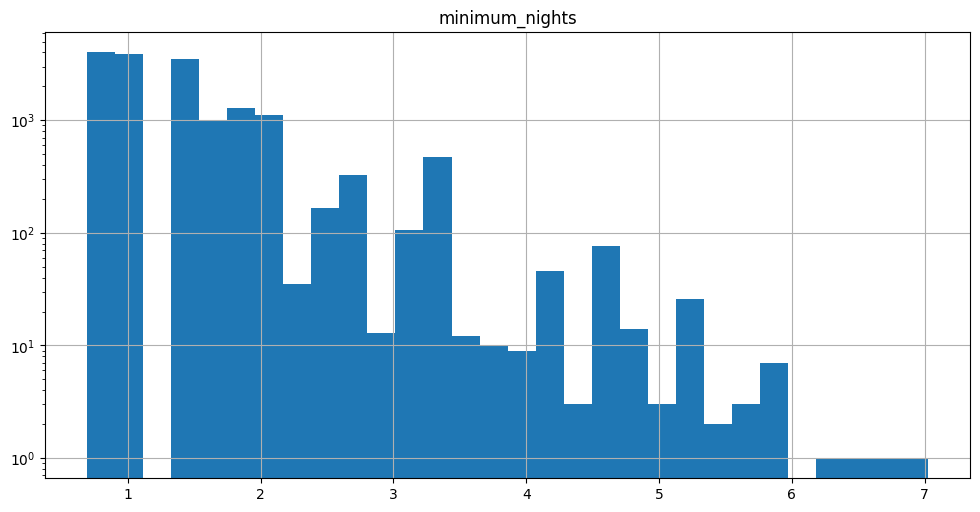

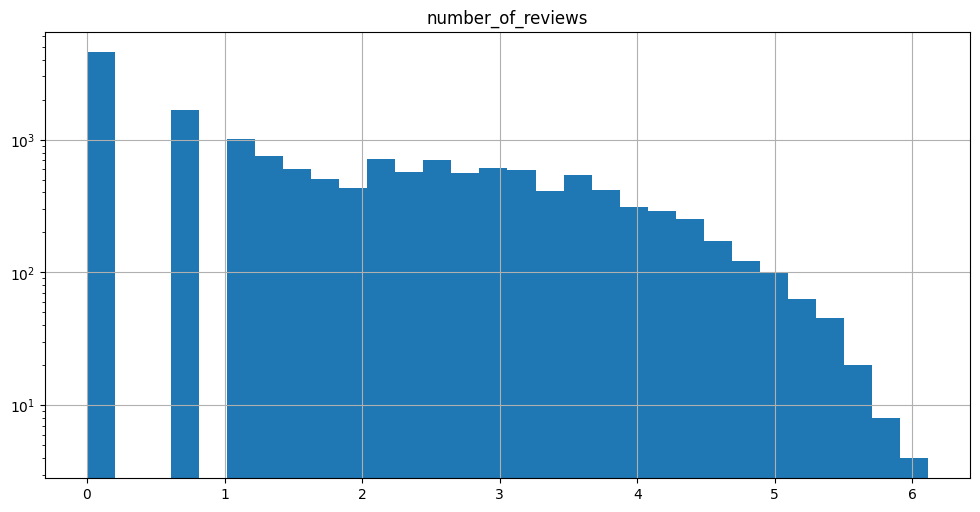

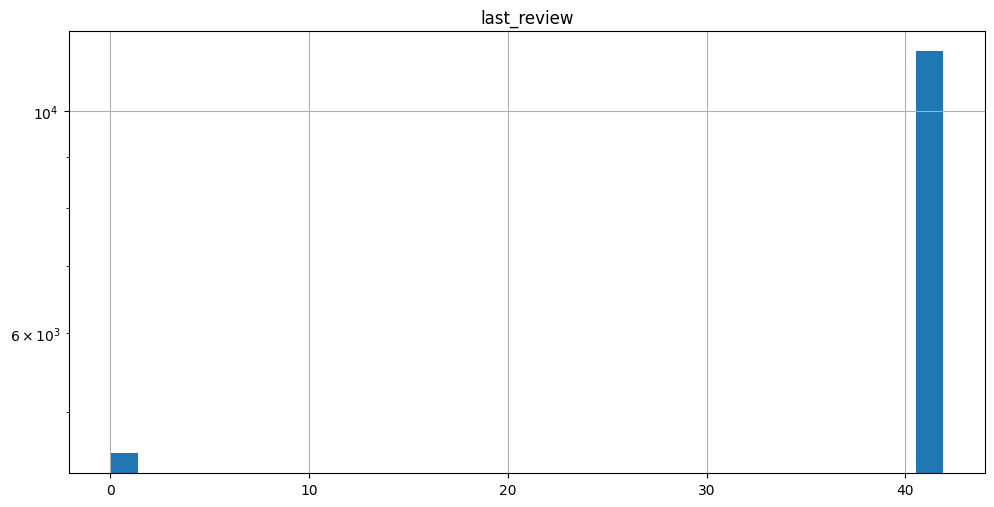

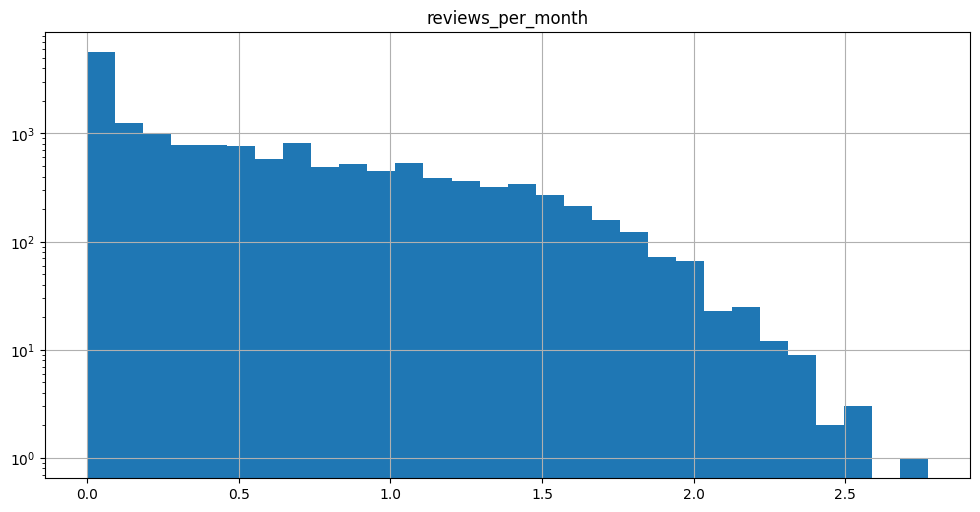

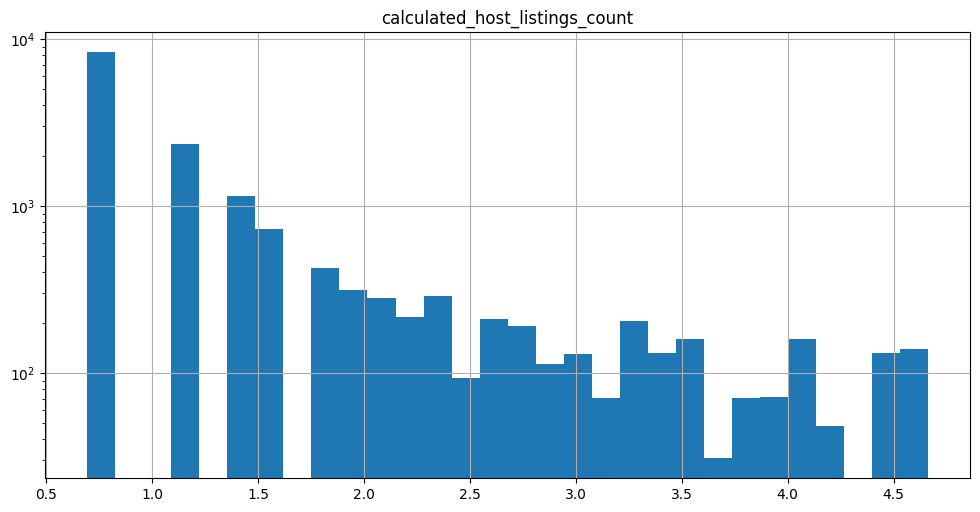

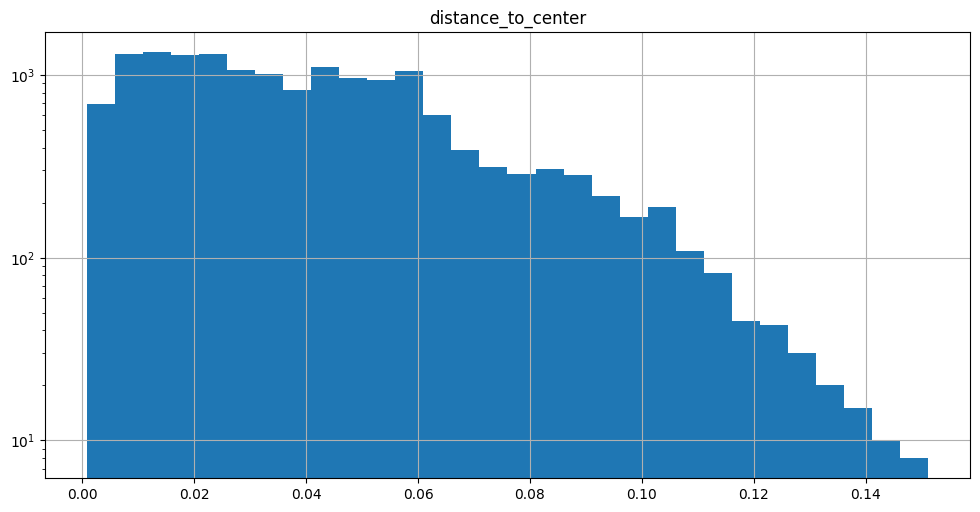

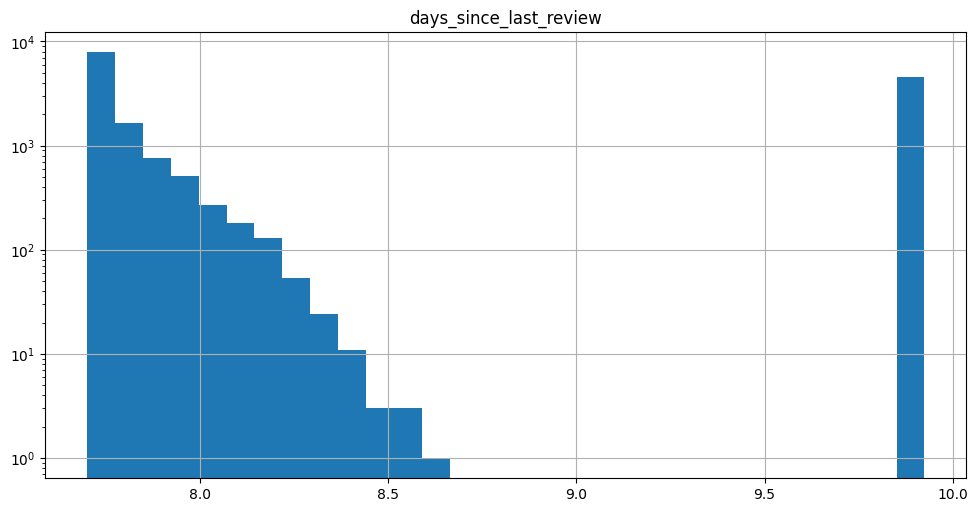

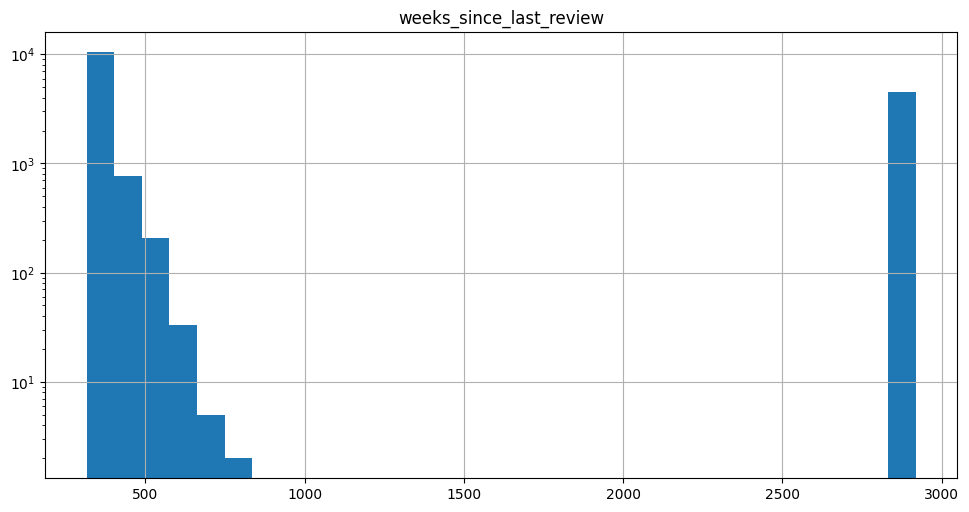

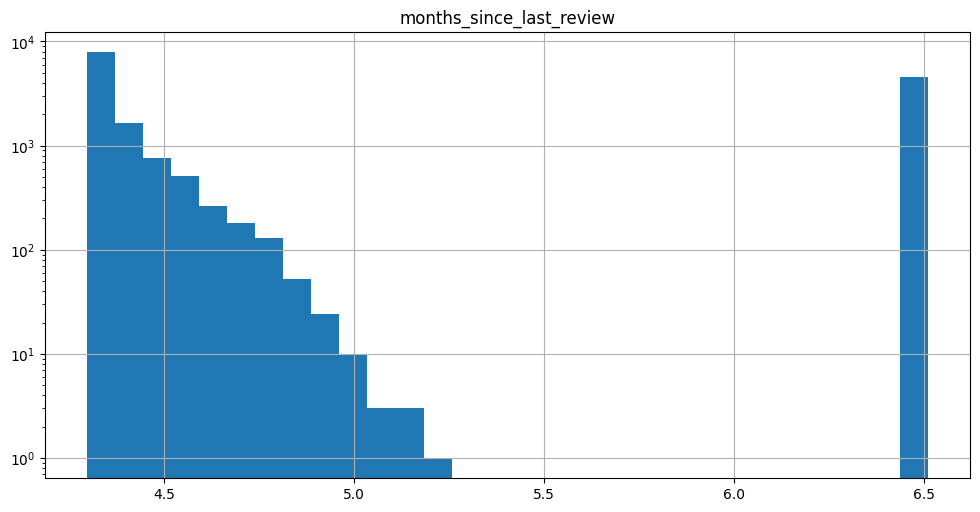

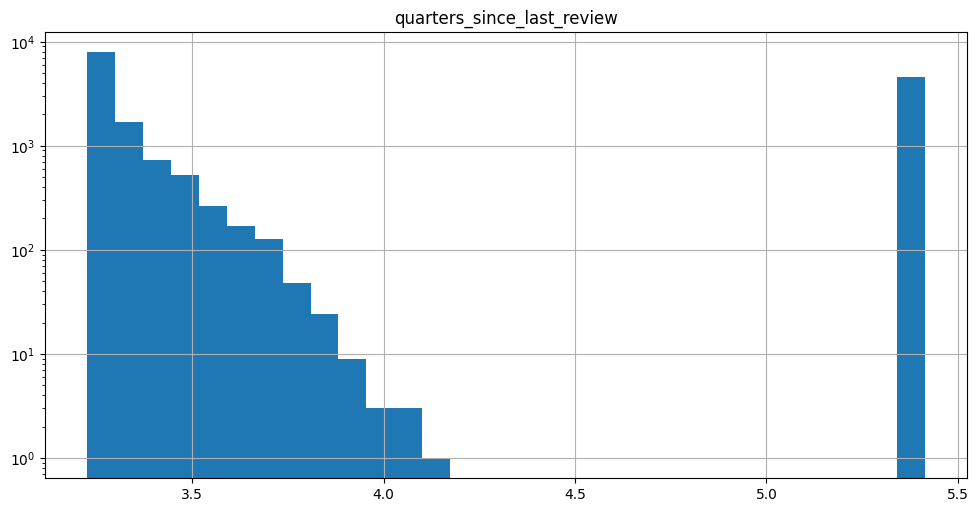

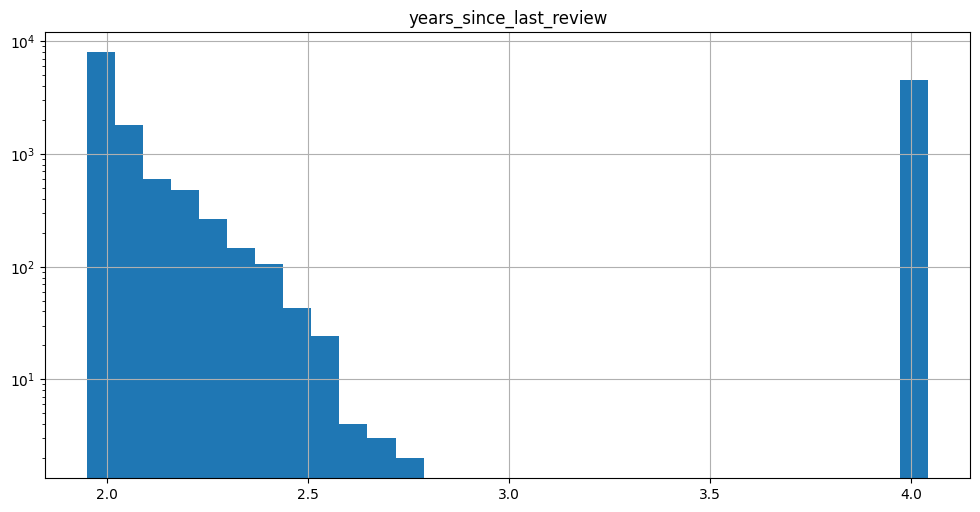

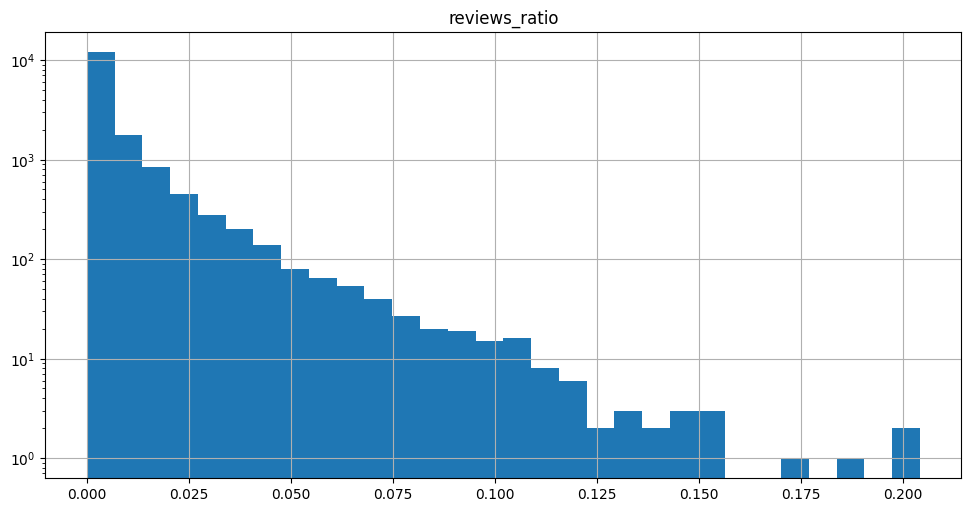

In [29]:
for col in numeric_cols:
  df[col].hist(bins=30, figsize=(10, 5))
  plt.tight_layout()
  plt.title(col)
  plt.yscale('log') # Set y-axis to log scale
  plt.show()

In [9]:
df = transform.transform(df)
dfTest = transform.transform(dfTest)

In [10]:
night_mapping = {
    'short': 1,
    'week': 2,
    'month': 3,
    'semi_year': 4,
    'long': 5
}

df['minimum_nights_num'] = df['minimum_nights_category'].map(night_mapping)
dfTest['minimum_nights_num'] = dfTest['minimum_nights_category'].map(night_mapping)

df = df.drop(['minimum_nights_category'], axis=1)
dfTest = dfTest.drop(['minimum_nights_category'], axis=1)


df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
dfTest_encoded = pd.get_dummies(dfTest, columns=categorical_cols, drop_first=True)

In [11]:
if outliersBefore != 0:
    print("Before: \n" + str(df_encoded.count()))
    numeric_cols = df_encoded.select_dtypes(include=np.number)

    Q1 = numeric_cols.quantile(outliersLower)
    Q3 = numeric_cols.quantile(outliersUpper)
    IQR = Q3 - Q1

    mask = ~((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR)))

    df_encoded = df_encoded[mask.all(axis=1)]
    print("After: \n" + str(df_encoded.count()))

In [12]:
Y = df_encoded['price']
X_encoded = df_encoded.drop('price', axis=1)

In [13]:
print(f"\nFeatures after one-hot encoding: {X_encoded.shape[1]}")
print(f"Feature names:\n{X_encoded.columns.tolist()}")


Features after one-hot encoding: 66
Feature names:
['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'distance_to_center', 'days_since_last_review', 'weeks_since_last_review', 'months_since_last_review', 'quarters_since_last_review', 'years_since_last_review', 'host_has_multiple_listings', 'reviews_ratio', 'minimum_nights_num', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'neighbourhood_Almagro', 'neighbourhood_Balvanera', 'neighbourhood_Barracas', 'neighbourhood_Belgrano', 'neighbourhood_Boca', 'neighbourhood_Boedo', 'neighbourhood_Caballito', 'neighbourhood_Chacarita', 'neighbourhood_Coghlan', 'neighbourhood_Colegiales', 'neighbourhood_Constitucion', 'neighbourhood_Flores', 'neighbourhood_Floresta', 'neighbourhood_Liniers', 'neighbourhood_Mataderos', 'neighbourhood_Monserrat', 'neighbourhood_Monte Castro', 'neighbourhood_Nueva Pompeya', 'neighbourhood_Nuñez', 'neighbour

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_encoded, Y, test_size=0.2, random_state=42
)


In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

In [16]:
if outliersAfter != 0:
    print("Before: " + str(X_train.count()))
    numeric_cols = X_train.select_dtypes(include=np.number)

    Q1 = numeric_cols.quantile(outliersLower)
    Q3 = numeric_cols.quantile(outliersUpper)
    IQR = Q3 - Q1

    mask = ~((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR)))

    X_train = X_train[mask.all(axis=1)]
    Y_train = Y_train[mask.all(axis=1)] # Apply the same mask to Y_train
    print("After: " + str(X_train.count()))

In [17]:
print(f"\n{'='*70}")
print("DATA SPLIT")
print(f"{'='*70}")
print(f"Train: {X_train.shape[0]} samples")
print(f"Val:   {X_val.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")



DATA SPLIT
Train: 10248 samples
Val:   2562 samples
Test:  3203 samples


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

dfTest_encoded_Scale = scaler.transform(dfTest_encoded)

In [19]:
regr_baseline = LinearRegression()
regr_baseline.fit(X_train, Y_train)

# Evaluate on all sets
for name, X, Y in [("Train", X_train, Y_train),
                     ("Validation", X_val, Y_val),
                     ("Test", X_test, Y_test)]:
    y_pred = regr_baseline.predict(X)
    # Apply inverse transformation to price predictions and actual values
    y_pred_original_scale = transform.untransform(y_pred) # Use transform.untransform
    Y_original_scale = transform.untransform(Y) # Use transform.untransform


    mae = mean_absolute_error(Y_original_scale, y_pred_original_scale)
    mse = mean_squared_error(Y_original_scale, y_pred_original_scale)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_original_scale, y_pred_original_scale)
    print(f"\n{name}:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R²:   {r2:.6f}")


Train:
  MAE:  $1,895.75
  RMSE: $14,420.04
  R²:   0.002210

Validation:
  MAE:  $1,460.59
  RMSE: $4,973.96
  R²:   0.030667

Test:
  MAE:  $1,914.03
  RMSE: $13,462.46
  R²:   0.000599


In [20]:

y_pred_test = regr_baseline.predict(dfTest_encoded)

# Apply inverse transformation
y_pred_test_original = transform.untransform(pd.Series(y_pred_test))

# Load the original test dataset to get the IDs
original_dfTest = pd.read_csv('../sample_data/test.csv')

# Create a DataFrame for the predictions with IDs
dfTest_with_predictions = pd.DataFrame({'id': original_dfTest['id'], 'price': y_pred_test_original})

# Save the predictions to a CSV file
dfTest_with_predictions.to_csv('predicted_prices_test_set.csv', index=False)

print("Predictions for the test set saved to 'predicted_prices_test_set.csv'")

Predictions for the test set saved to 'predicted_prices_test_set.csv'


In [21]:
regr_scaled = LinearRegression()
regr_scaled.fit(X_train_scaled, Y_train)

# Evaluate on all sets
for name, X, Y in [("Train", X_train_scaled, Y_train),
                     ("Validation", X_val_scaled, Y_val),
                     ("Test", X_test_scaled, Y_test)]:
    y_pred = regr_scaled.predict(X)
    # Apply inverse transformation to price predictions and actual values
    y_pred_original_scale = transform.untransform(y_pred) # Use transform.untransform
    Y_original_scale = transform.untransform(Y) # Use transform.untransform


    mae = mean_absolute_error(Y_original_scale, y_pred_original_scale)
    mse = mean_squared_error(Y_original_scale, y_pred_original_scale)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_original_scale, y_pred_original_scale)
    print(f"\n{name}:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R²:   {r2:.6f}")


Train:
  MAE:  $1,895.66
  RMSE: $14,420.34
  R²:   0.002168

Validation:
  MAE:  $1,460.93
  RMSE: $4,973.97
  R²:   0.030663

Test:
  MAE:  $1,913.17
  RMSE: $13,461.98
  R²:   0.000670


In [22]:
y_pred_test_scaled = regr_scaled.predict(dfTest_encoded_Scale)

# Apply inverse transformation
y_pred_test_original_scale = transform.untransform(pd.Series(y_pred_test_scaled))

# Load the original test dataset to get the IDs
original_dfTest = pd.read_csv('../sample_data/test.csv')

# Create a DataFrame for the predictions with IDs
dfTest_with_predictions_scaled = pd.DataFrame({'id': original_dfTest['id'], 'price': y_pred_test_original_scale})

# Save the predictions to a CSV file
dfTest_with_predictions_scaled.to_csv('scaled_predicted_prices_test_set.csv', index=False)

print("Predictions for the test set saved to 'scaled_predicted_prices_test_set.csv'")

Predictions for the test set saved to 'scaled_predicted_prices_test_set.csv'


In [23]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, Y_train)

for name, X, Y in [("Train", X_train_scaled, Y_train),
                   ("Validation", X_val_scaled, Y_val),
                   ("Test", X_test_scaled, Y_test)]:
    y_pred = ridge.predict(X)

    # Untransform BEFORE calculating metrics
    y_pred_original = transform.untransform(pd.Series(y_pred, index=Y.index))
    Y_original = transform.untransform(Y)

    # Calculate ALL metrics on original scale
    mae = mean_absolute_error(Y_original, y_pred_original)
    mse = mean_squared_error(Y_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_original, y_pred_original)  # Recalculate!

    print(f"\n{name}:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R²:   {r2:.6f}")


Train:
  MAE:  $1,895.70
  RMSE: $14,419.70
  R²:   0.002256

Validation:
  MAE:  $1,459.50
  RMSE: $4,972.45
  R²:   0.031255

Test:
  MAE:  $1,914.93
  RMSE: $13,463.30
  R²:   0.000474


In [24]:
ridge = Ridge(alpha=1.0)  # Tune this hyperparameter
ridge.fit(X_train_scaled, Y_train)

# Evaluate on all sets
for name, X, Y in [("Train", X_train_scaled, Y_train),
                     ("Validation", X_val_scaled, Y_val),
                     ("Test", X_test_scaled, Y_test)]:
    y_pred = ridge.predict(X)
    # Apply inverse transformation to price predictions and actual values
    y_pred_original_scale = transform.untransform(pd.Series(y_pred)) # Use transform.untransform
    Y_original_scale = transform.untransform(Y) # Use transform.untransform

    mae = mean_absolute_error(Y_original_scale, y_pred_original_scale)
    mse = mean_squared_error(Y_original_scale, y_pred_original_scale)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_original_scale, y_pred_original_scale)
    print(f"\n{name}:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R²:   {r2:.6f}")


Train:
  MAE:  $1,895.70
  RMSE: $14,419.70
  R²:   0.002256

Validation:
  MAE:  $1,459.50
  RMSE: $4,972.45
  R²:   0.031255

Test:
  MAE:  $1,914.93
  RMSE: $13,463.30
  R²:   0.000474


In [25]:
lasso = Lasso(alpha=10.0, max_iter=10000)  # Tune this hyperparameter
lasso.fit(X_train_scaled, Y_train)

# Show which features were selected (non-zero coefficients)
selected_features = np.sum(lasso.coef_ != 0)
print(f"\nFeatures selected by LASSO: {selected_features}/{X_train_scaled.shape[1]}")

# Evaluate on all sets
for name, X, Y in [("Train", X_train_scaled, Y_train),
                     ("Validation", X_val_scaled, Y_val),
                     ("Test", X_test_scaled, Y_test)]:
    y_pred = lasso.predict(X)
    # Apply inverse transformation to price predictions and actual values
    y_pred_original_scale = transform.untransform(pd.Series(y_pred)) # Use transform.untransform
    Y_original_scale = transform.untransform(Y) # Use transform.untransform

    mae = mean_absolute_error(Y_original_scale, y_pred_original_scale)
    mse = mean_squared_error(Y_original_scale, y_pred_original_scale)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_original_scale, y_pred_original_scale)
    print(f"\n{name}:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R²:   {r2:.6f}")


Features selected by LASSO: 0/66

Train:
  MAE:  $2,128.00
  RMSE: $14,496.79
  R²:   -0.008440

Validation:
  MAE:  $1,667.32
  RMSE: $5,122.98
  R²:   -0.028285

Test:
  MAE:  $2,144.31
  RMSE: $13,534.93
  R²:   -0.010189
